## Aprendizado Multiobjetivo em Modelos Supervisionados

**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres


---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


---

### 1. Base de Dados:
O dataset utilizado nesse código é o [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance), que contém dados de alunos de duas escolas do ensino médio, o qual contém 649 instâncias e 30 features. Utilizamos métodos de **regressão** para predição e análise, com a variável G3 (nota final) como **target**. O dataset tem bastante features para poucos dados, e por isso, decidimos selecionar aquelas que consideramos fazer mais sentido ou que tem uma relação positiva com a variável target, como:

- **G1**: nota do primeiro período
- **G2**: nota do segundo período
- **Medu**: nível de educação da mãe
- **Fedu**: nível de educação da mãe
- **Walc**: consumo de álcool no final de semana
- **absences**: número de faltas
- **studytime**: tempo de estudo semanal
- **failures**: número de reprovações anteriores
- **health**: estado atual de saúde


In [3]:
# ------------------ STUDENT PERFORMANCE ------------------
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 

# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 
  
# metadata 
print(student_performance.metadata) 
  
# variable information 
print(student_performance.variables) 

np.random.seed(42)
tf.random.set_seed(42)


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [4]:
# ------------------------- Preprocess dataset -------------------------
# Juntar X e y primeiro para garantir consistência
df = pd.concat([X, y], axis=1)

# Verificar quais colunas realmente existem no DataFrame
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

# Colunas categóricas esperadas
expected_cat_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus',
    'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

# Filtrar apenas as colunas que existem no DataFrame
cat_cols = [col for col in expected_cat_cols if col in df.columns]

print("\nColunas categóricas que serão codificadas:")
print(cat_cols)

print("\nValores faltantes antes do tratamento:")
print(df.isnull().sum())

# Preencher valores faltantes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# One-hot encoding apenas nas colunas categóricas existentes
df = pd.get_dummies(df, columns=cat_cols)

X = df.drop(columns=y.columns)
y = df[y.columns]

print("\nNúmero de amostras em X e y:")
print(len(X), len(y))

df.head()

Colunas disponíveis no DataFrame:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Colunas categóricas que serão codificadas:
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Valores faltantes antes do tratamento:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel 

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
2,15,1,1,1,2,0,4,3,2,2,...,True,False,False,True,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False


In [5]:
# ------------------- Train/Test split -------------------
# Selecionando features relevantes e target
feat = ['G1', 'G2', 'Medu', 'Fedu', 'Walc', 'absences', 'studytime', 'failures', 'health']
features = df[feat]
target = df['G3'] # Nota final do aluno

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\nShapes após train/test split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


print("\nValores NaN em X_train:", X_train.isna().sum().sum())
print("Valores NaN em y_train:", y_train.isna().sum().sum())


Shapes após train/test split:
X_train: (454, 9), y_train: (454,)
X_test: (195, 9), y_test: (195,)

Valores NaN em X_train: 0
Valores NaN em y_train: 0


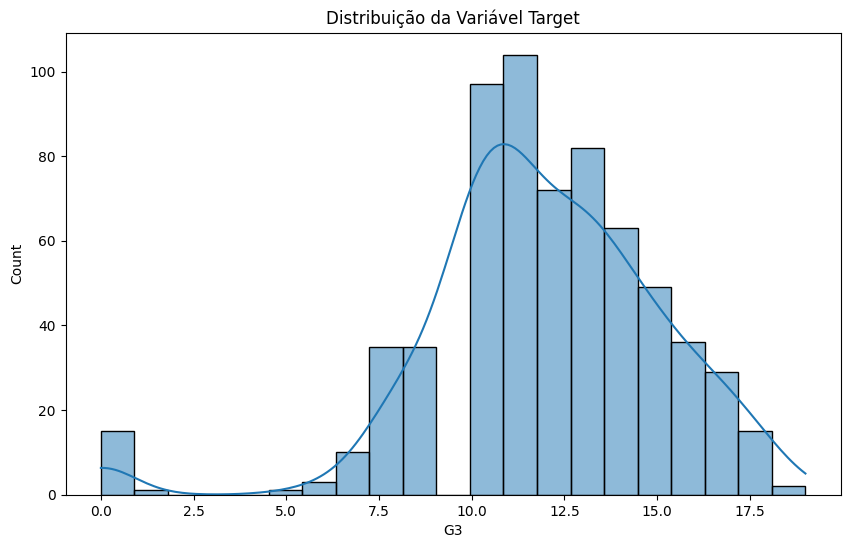

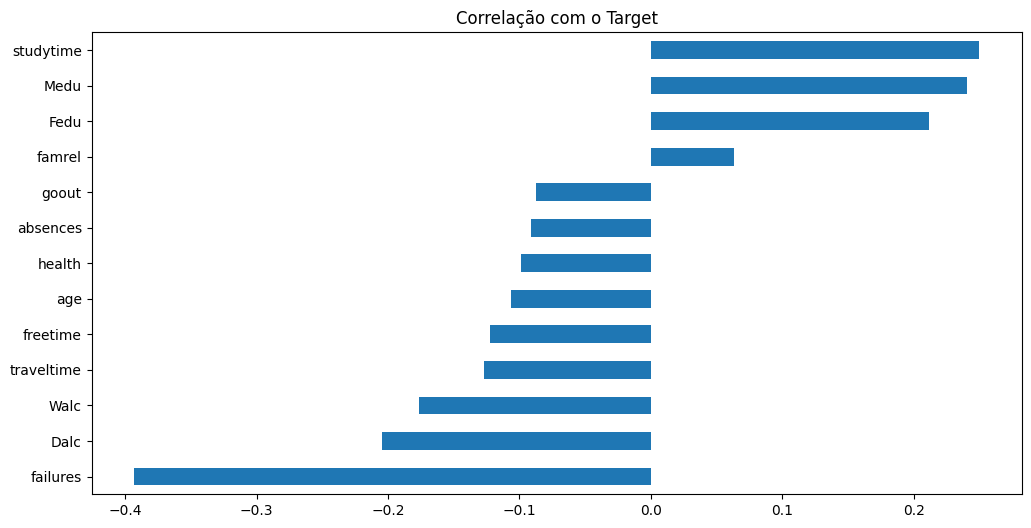

In [50]:
# Verificar distribuição do target
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True) # y.iloc[:, 0]
plt.title('Distribuição da Variável Target')
plt.show()

# Correlação entre features numéricas e target
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_features].corrwith(target)
plt.figure(figsize=(12, 6))
correlations.sort_values().plot.barh()
plt.title('Correlação com o Target')
plt.show()

---

### 2. Modelagem com Algoritmos Supervisionados:
Utilizamos três modelos com diferentes arquiteturas/configurações, sendo eles:
- **Rede Neural:** Com arquitetura de 1 (32), 2 (64, 32) e 3 (128, 64, 32) camadas;
- **MLP**: Camadas ocultas de 50, 100, 200, 300 e 500;
- **Árvore de Decisão:** Sendo as profundidades máximas 3, 5, 10, 20 e nenhuma;
- **Random Forest:** Sendo o número de árvores 50, 100 e 200 e profundidades máximas como 5, 10, 30 e nenhuma.

Além disso, estaremos extraindo de cada modelo e configuração as features mais **relevantes** e métricas de desempenho, como a MSE, RMSE e R².

In [51]:
# ------------------------- Random Forest Regressor -------------------------

n_estimators_list = [50, 100, 200]      # Número de árvores
max_depth_list = [5, 10, 30, None]      # Profundidade máxima

results_rf = []

# Verificar e garantir que y_train seja 1D
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.values.ravel()

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        RFR = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            criterion='squared_error', 
            min_samples_leaf=5, 
            n_jobs=1,
            random_state=42
        )
        RFR.fit(X_train, y_train)
        
        # Métricas
        y_pred = RFR.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Complexidade
        avg_depth = np.mean([tree.tree_.max_depth for tree in RFR.estimators_])
        n_params = sum(tree.tree_.n_node_samples.size for tree in RFR.estimators_)
        
        results_rf.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'avg_depth': avg_depth,
            'n_params': n_params,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

        # Guardando features relevantes
        feature_importance = RFR.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\nFeatures mais relevantes para Random Forest - Profundidade máxima {max_depth} | Árvores {n_estimators}:")
        print(importance_df.head())

        """
        # Plotagem das predições
        
        plt.scatter(y_test, y_pred)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Valores Reais')
        plt.ylabel('Predições')
        plt.title(f'Predições vs Reais (R² = {r2:.2f}) - n_estimators={n_estimators}, max_depth={max_depth}')
        plt.show()

        """



Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 50:
    Feature  Importance
1        G2    0.911189
5  absences    0.046537
0        G1    0.017496
8    health    0.007661
3      Fedu    0.004757

Features mais relevantes para Random Forest - Profundidade máxima 10 | Árvores 50:
    Feature  Importance
1        G2    0.900750
5  absences    0.048163
0        G1    0.019451
8    health    0.008743
4      Walc    0.005849

Features mais relevantes para Random Forest - Profundidade máxima 30 | Árvores 50:
    Feature  Importance
1        G2    0.900732
5  absences    0.048164
0        G1    0.019451
8    health    0.008750
4      Walc    0.005849

Features mais relevantes para Random Forest - Profundidade máxima None | Árvores 50:
    Feature  Importance
1        G2    0.900732
5  absences    0.048164
0        G1    0.019451
8    health    0.008750
4      Walc    0.005849

Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 100:
   

In [52]:
# ------------------------- Decision Tree Regressor -------------------------

max_depth_list = [3, 5, 10, 20, None]
results_dt = []

for max_depth in max_depth_list:
    print(f"\n=== Modelo com profundidade máxima {max_depth} ===")
    DTR = DecisionTreeRegressor(
        max_depth=max_depth,
        criterion='squared_error',
        min_samples_leaf=5, 
        random_state=42
    )
    DTR.fit(X_train, y_train)
    
    # Métricas
    y_pred = DTR.predict(X_test)
    mse = mean_squared_error(y_test, y_pred) # média dos erros quadráticos entre predições e valores reais
    rmse= np.sqrt(mse) # raiz quadrada do erro médio quadrático, menor melhor
    r2 = r2_score(y_test, y_pred) # proporção da variância explicada pelo modelo [0, 1]
    
    # Complexidade
    n_nodes = DTR.tree_.node_count
    depth = DTR.tree_.max_depth
    
    results_dt.append({
        'max_depth_set': max_depth,
        'actual_depth': depth,
        'n_nodes': n_nodes,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
     })

    # Guardando features relevantes
    feature_importance = DTR.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nFeatures mais relevantes para Decision Tree - Profundidade máxima {max_depth}:")
    print(importance_df.head())


    """
    # Plotagem das predições

    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Profundidade máxima = {max_depth}')
    plt.show()

    """



=== Modelo com profundidade máxima 3 ===

Features mais relevantes para Decision Tree - Profundidade máxima 3:
  Feature  Importance
1      G2    0.997869
8  health    0.002131
0      G1    0.000000
3    Fedu    0.000000
2    Medu    0.000000

=== Modelo com profundidade máxima 5 ===

Features mais relevantes para Decision Tree - Profundidade máxima 5:
    Feature  Importance
1        G2    0.945798
0        G1    0.021615
5  absences    0.016898
3      Fedu    0.005309
7  failures    0.004697

=== Modelo com profundidade máxima 10 ===

Features mais relevantes para Decision Tree - Profundidade máxima 10:
    Feature  Importance
1        G2    0.915358
0        G1    0.024599
4      Walc    0.018935
5  absences    0.018286
3      Fedu    0.006573

=== Modelo com profundidade máxima 20 ===

Features mais relevantes para Decision Tree - Profundidade máxima 20:
    Feature  Importance
1        G2    0.915083
0        G1    0.024585
4      Walc    0.018947
5  absences    0.018036
3      F


=== Modelo com 1 camada(s) ===
Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 155.1980 - mae: 11.7851 - val_loss: 146.3129 - val_mae: 11.7508
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 151.6917 - mae: 11.6986 - val_loss: 144.0045 - val_mae: 11.6706
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 145.0055 - mae: 11.5126 - val_loss: 141.6171 - val_mae: 11.5858
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 143.2430 - mae: 11.4755 - val_loss: 138.9230 - val_mae: 11.4872
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 141.3663 - mae: 11.4785 - val_loss: 136.1402 - val_mae: 11.3826
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138.3560 - mae: 11.3625 - val_loss: 133.2964 - val_mae: 11.2779
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 134.6164 - mae: 11.2521 - val_loss: 130.4292 - val_mae: 11.1727
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 132.0705 - mae: 11.1736 - val_loss: 127.3125 - val_mae: 11.0539
Epoch 9/200
12/12 ━━━━━━━━━

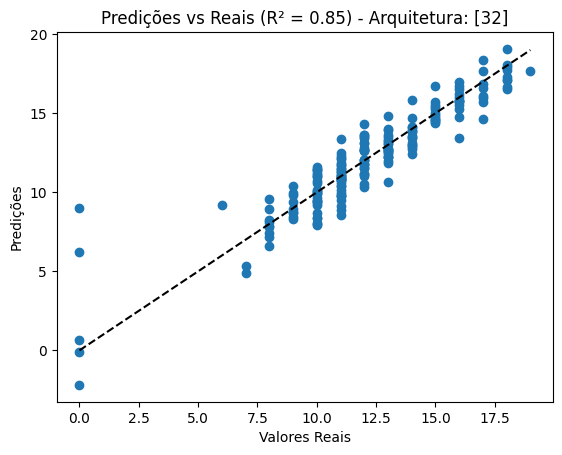


=== Modelo com 2 camada(s) ===
Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 140.6268 - mae: 11.3645 - val_loss: 142.7827 - val_mae: 11.6421
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 124.1131 - mae: 10.7166 - val_loss: 136.0111 - val_mae: 11.3699
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 108.3711 - mae: 10.0244 - val_loss: 127.7722 - val_mae: 11.0286
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 93.8162 - mae: 9.2999 - val_loss: 117.9169 - val_mae: 10.6045
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78.9391 - mae: 8.5414 - val_loss: 106.1713 - val_mae: 10.0750
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62.3962 - mae: 7.5531 - val_loss: 92.9806 - val_mae: 9.4394
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48.7148 - mae: 6.5570 - val_loss: 79.4561 - val_mae: 8.7279
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.0112 - mae: 5.4862 - val_loss: 67.2470 - val_mae: 8.0176
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 

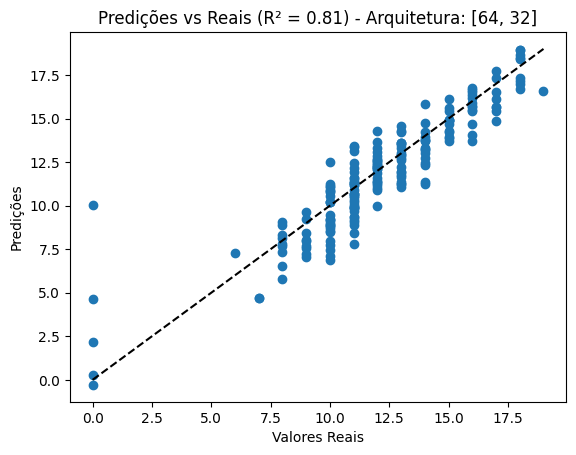


=== Modelo com 3 camada(s) ===
Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 125.8273 - mae: 10.6966 - val_loss: 134.5354 - val_mae: 11.2639
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.3096 - mae: 8.0446 - val_loss: 114.8328 - val_mae: 10.4105
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.3504 - mae: 5.0181 - val_loss: 92.4580 - val_mae: 9.3500
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.4141 - mae: 2.8660 - val_loss: 80.7074 - val_mae: 8.7328
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.1167 - mae: 2.2889 - val_loss: 83.3551 - val_mae: 8.8620
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6685 - mae: 1.9966 - val_loss: 84.5531 - val_mae: 8.9273
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1450 - mae: 1.7659 - val_loss: 81.1762 - val_mae: 8.7486
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8878 - mae: 1.6872 - val_loss: 77.0301 - val_mae: 8.5183
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - los

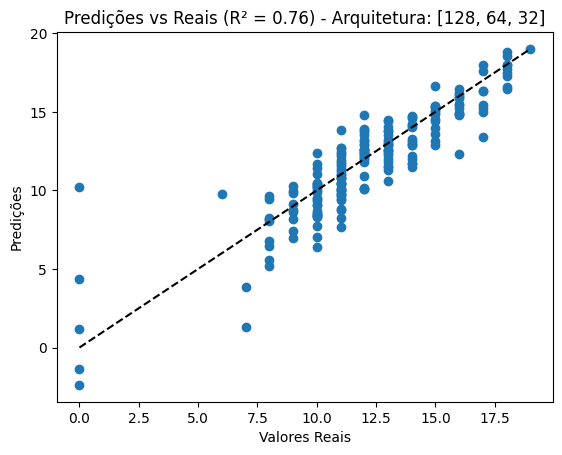

In [53]:
# ------------------------- Neural Network Regressor -------------------------
architectures = [
    [32],               # 1 camada
    [64, 32],           # 2 camadas
    [128, 64, 32]       # 3 camadas
]

results_nn = []

for architecture in architectures:
    print(f"\n=== Modelo com {len(architecture)} camada(s) ===")
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Dense(architecture[0], 
                              activation='relu', 
                              input_shape=(X_train_scaled.shape[1],)
        ),
    )
    # Batch normalization para estabilizar a aprendizagem
    model.add(tf.keras.layers.BatchNormalization())
    # Dropout para evitar overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    for units in architecture[1:]:
        model.add(tf.keras.layers.Dense(
                units, 
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        
    
    model.add(tf.keras.layers.Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer, 
        loss='mse', 
        metrics=['mae'])

    # Early stopping para evitar overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss',
        mode='min', 
        restore_best_weights=True)

    model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        shuffle=True,
        verbose=1
    )
    
    # Métricas
    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_params = model.count_params()
    
    results_nn.append({
        'architecture': str(architecture),
        'n_params': n_params,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Guardando features relevantes da primeira camada
    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("Features mais relevantes para primeira camada da NN:")
    print(importance_df.head())

    # Plotagem das predições
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Arquitetura: {architecture}')
    plt.show()


In [54]:
# ------------------------- MLP Regressor -------------------------
hidden_layers = [50, 100, 200, 300, 500]  # Número de neurônios nas camadas ocultas
results_mlp = []

# Função para contar o número de parâmetros em um MLP
def count_mlp_params(mlp):
    n_params = 0
    for weights in mlp.coefs_:
        n_params += weights.size
    for bias in mlp.intercepts_:
        n_params += bias.size
    return n_params

for layer in hidden_layers:
    print(f"\n=== Modelo com {layer} camadas ===")
    
    model = MLPRegressor(
        hidden_layer_sizes=(layer,), 
        max_iter=1000,
        solver='adam', 
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Métricas de classificação
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_params = count_mlp_params(model)
    
    results_mlp.append({
        'hidden_layers': layer,
        'n_params': n_params,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Features relevantes
    weights = model.coefs_[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 features mais relevantes:")
    print(importance_df.head())
    
    """
    # Plotagem das predições
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Número de camadas ocultas = {layer}')
    plt.show()
    """




=== Modelo com 50 camadas ===


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Top 5 features mais relevantes:
    Feature  Importance
4      Walc    0.291686
0        G1    0.262643
7  failures    0.255385
3      Fedu    0.245466
8    health    0.236393

=== Modelo com 100 camadas ===


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Top 5 features mais relevantes:
    Feature  Importance
5  absences    0.232440
4      Walc    0.219571
7  failures    0.207941
0        G1    0.200483
2      Medu    0.194672

=== Modelo com 200 camadas ===


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Top 5 features mais relevantes:
     Feature  Importance
6  studytime    0.161118
4       Walc    0.157163
0         G1    0.157094
7   failures    0.149924
5   absences    0.147545

=== Modelo com 300 camadas ===


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Top 5 features mais relevantes:
    Feature  Importance
4      Walc    0.148231
7  failures    0.140979
8    health    0.140519
0        G1    0.138917
5  absences    0.135529

=== Modelo com 500 camadas ===

Top 5 features mais relevantes:
     Feature  Importance
6  studytime    0.123059
4       Walc    0.120852
7   failures    0.119489
8     health    0.115697
0         G1    0.114558


---

### 3. Critérios de Avaliação:
**Erro de predição**: utilizar métricas como MSE, RMSE, acurácia, F1-score, conforme o tipo de problema.

**Complexidade do modelo**:
* **Redes neurais**: número de parâmetros treináveis.
* **Árvores de decisão**: profundidade ou número de nós.
* **Random Forest**: número de árvores e profundidade média.

In [55]:
# ------------------------- Visualização das métricas -------------------------
print("\nResultados da MLP:")
df_results_mlp = pd.DataFrame(results_mlp)
print(df_results_mlp.sort_values('R2', ascending=False))



Resultados da MLP:
   hidden_layers  n_params     MSE     RMSE        R2
0             50       551  2.6029  1.61335  0.764617
1            100      1101  2.6029  1.61335  0.764617
2            200      2201  2.6029  1.61335  0.764617
3            300      3301  2.6029  1.61335  0.764617
4            500      5501  2.6029  1.61335  0.764617


In [56]:
print("\nResultados da Rede Neural:")
df_results_nn = pd.DataFrame(results_nn)
print(df_results_nn.sort_values('R2', ascending=False))


Resultados da Rede Neural:
    architecture  n_params       MSE      RMSE        R2
0           [32]       481  1.654346  1.286214  0.850396
1       [64, 32]      3009  2.085184  1.444017  0.811435
2  [128, 64, 32]     12161  2.602900  1.613350  0.764617


In [57]:
print("\nResultados do Random Forest:")
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf.sort_values('R2', ascending=False))



Resultados do Random Forest:
    n_estimators  max_depth  avg_depth  n_params       MSE      RMSE        R2
8            200        5.0      5.000      9782  1.461456  1.208907  0.867839
0             50        5.0      5.000      2488  1.477850  1.215669  0.866356
4            100        5.0      5.000      4926  1.478464  1.215921  0.866301
9            200       10.0      8.980     17776  1.482328  1.217509  0.865952
11           200        NaN      9.045     17806  1.482804  1.217705  0.865908
10           200       30.0      9.045     17806  1.482804  1.217705  0.865908
1             50       10.0      8.780      4448  1.496466  1.223301  0.864673
2             50       30.0      8.860      4460  1.497272  1.223631  0.864600
3             50        NaN      8.860      4460  1.497272  1.223631  0.864600
5            100       10.0      8.910      8866  1.497505  1.223726  0.864579
7            100        NaN      8.990      8886  1.497932  1.223901  0.864540
6            100      

In [62]:
print("\nResultados do Decision Tree:")
df_results_dt = pd.DataFrame(results_dt)
print(df_results_dt.sort_values('R2', ascending=False))


Resultados do Decision Tree:
   max_depth_set  actual_depth  n_nodes       MSE      RMSE        R2
1            5.0             5       55  1.741737  1.319749  0.842493
0            3.0             3       15  1.816562  1.347799  0.835726
2           10.0            10      145  2.014091  1.419187  0.817864
3           20.0            11      149  2.017525  1.420396  0.817553
4            NaN            11      149  2.017525  1.420396  0.817553


---

### 4. Otimização Multiobjetivo:
A abordagem utilizada para encontrar modelos que equilibrem desempenho e complexidade foi a análise e visualização da **Fronteira de Pareto**.

In [59]:
# ------------------------- Análise Multiobjetivo -------------------------

# Adicionar coluna de modelo para cada DataFrame
df_results_nn['model'] = 'Neural Network'
df_results_mlp['model'] = 'MLP Regressor'
df_results_rf['model'] = 'Random Forest'
df_results_dt['model'] = 'Decision Tree'

# Selecionando apenas colunas relevantes
df_results_dt = df_results_dt[['n_nodes', 'R2']]
df_results_dt['n_params'] = df_results_dt['n_nodes']
df_results_rf = df_results_rf[['n_params', 'R2']]
df_results_nn = df_results_nn[['n_params', 'R2']]
df_results_mlp = df_results_mlp[['n_params', 'R2']]

# Unificando resultados em um dataframe
df_all = pd.concat([
    df_results_nn.assign(model='Neural Network'),
    df_results_mlp.assign(model='MLP Regressor'),
    df_results_rf.assign(model='Random Forest'),
    df_results_dt.assign(model='Decision Tree')
], ignore_index=True)

In [60]:
def is_pareto_efficient(df):
    data = df[['n_params', 'R2']].copy()
    # Muda R² para -R² para poder usar algoritmo de minimização
    data['R2'] = -data['R2']
    # Convertendo para numpy array
    costs = data.to_numpy()
    
    # Inicializa um array booleano para identificar soluções eficientes
    is_efficient = np.ones(costs.shape[0], dtype=bool)

    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Verifica se há outras soluções que são melhores ou iguais em todos os objetivos
            # descarta soluções que são dominadas
            is_efficient[is_efficient] = (
                np.any(costs[is_efficient] < c, axis=1) | 
                np.all(costs[is_efficient] == c, axis=1)
            )
            is_efficient[i] = True # garante que a solução atual é considerada eficiente
    return is_efficient


df_all['pareto'] = is_pareto_efficient(df_all)
pareto_df = df_all[df_all['pareto']] # DataFrame com soluções eficientes de Pareto


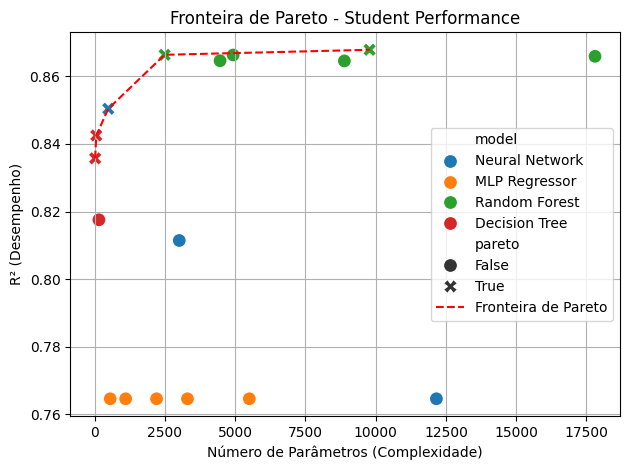

In [61]:
# ------------------------- Visualização da Fronteira de Pareto -------------------------
sns.scatterplot(
    data=df_all, 
    x='n_params', 
    y='R2', 
    hue='model', 
    style='pareto', 
    s=100)

pareto_sorted = pareto_df.sort_values('n_params')

plt.plot(
    pareto_sorted['n_params'], 
    pareto_sorted['R2'], 
    linestyle='--', 
    color='red', 
    label='Fronteira de Pareto')


plt.xlabel('Número de Parâmetros (Complexidade)')
plt.ylabel('R² (Desempenho)')
plt.title('Fronteira de Pareto - Student Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Melhores Modelos
1. **Random Forest (n_estimators = 200, max_depth = 5) - 0.86** 

maioria dos modelos foram bem. os melhores foram os que tiveram profundidade limitada a 5. apesar do modelo com 200 árvores ter tido a métrica R² melhor, o modelo com 50 árvores teve uma métrica bem parecida e usando bem menos parâmetros (2442 versus 9636).

2. **Neural Network Regressor (1 Camada) - 0.85**

modelos com mais camadas foram horríveis quanto mais aumentava, mas um modelo com uma só camada com 32 neurônios conseguiu ter uma performance quase semelhante com a da Random Forest (ainda inferior) e com bem menos parâmetros (449). é interessante observar que, ainda que o modelo de duas camadas tenham pegados features mais relevantes que o primeiro, teve uma performance inferior ao modelo de 1 camada.

3. **Decision Tree (max_depth = 5) - 0.83**

aumentar a profundidade máxima não melhorou muita coisa, visto que a profundidade máxima alcançada foi 11 e não houve melhoras de desempenho ao aumentar para além de 5. teve uma performance um pouco inferior a neural network, com bem menos número de nós (53).

4. **MLP Regressor - 0.76**

terrível, aumentar o número de camadas ocultas não melhora muita coisa também. usa muitos parâmetros e não tem a métrica R² próxima dos outros modelos. além disso, é possível observar que por algum motivo, esse modelo não dá importância pras features que melhores preveem o target, que é o caso da G1 e G2.

## Observações

Apesar do desempenho da Random Forest ter sido melhor, é importante analisar cuidadosamente a importância que cada modelo deu para as features. No caso desse modelo, podemos verificar que a segunda nota (G2) foi basicamente o que mais foi usado para prever a variável target. Mesmo aumentando a profundida das árvores, o foco do modelo foi na feature G2, o que indica uma dependência forte apenas no histórico escolar do aluno. Para uma predição rápida, apesar da correlação superficial.

Já para a Rede Neural, podemos observar uma tentativa de capturar nuances de outras features, como o número de faltas, tempo de estudo, nível de educação do pai e consumo de alcool nos fins de semana, indicando uma maior capacidade de predição mesmo sem as notas anteriores dos alunos. Seria um modelo interessante para analisar casos de risco ou inconsistências.
